In [1]:
import numpy as np
import matplotlib.pyplot as plt
import recoil_nuclear_classes_and_defs as cnst
from model_electric_field import EF_dict, X, Y, r_sphere, l_needle, r_needle, x_min, x_max, x, y, needle_cords_1
from scipy.interpolate import RegularGridInterpolator


In [2]:
RN_mass = 223
RN_charge = 2*cnst.CHARGE_ELECRON
RN_velocity = 370_000 #m/s

radius_cam = 0.07 # m
P = 5*10e-5 #Pa
volume_cam = 4/3*np.pi*radius_cam**3

air_area = cnst.Air(P, volume_cam, T=300)
N = 20

dx = 0.00014

In [3]:
Efield_6cm_100V_x, Efield_6cm_100V_y  = EF_dict["E_x"][0], EF_dict["E_y"][0]

In [16]:
max_traect = np.arange(x_min, x_max, dx)

x_serf, y_serf = cnst.source_surface(X, Y, r_sphere=r_sphere)
xhalf, yhalf = cnst.source_halph_surface(r_sphere=r_sphere)


In [5]:
E_field_6cm_100V = EF_dict["E_res"][0]
E_field_interp_x = RegularGridInterpolator((x, y), Efield_6cm_100V_x)
E_field_interp_y = RegularGridInterpolator((x, y), Efield_6cm_100V_y)
E_field_interp_res = RegularGridInterpolator((x, y), E_field_6cm_100V, bounds_error=False)
def electric_field_interp(pos):
    E_xx = E_field_interp_x(pos)
    E_yy = E_field_interp_y(pos)
    return np.array([E_xx, E_yy])


In [6]:
r = np.zeros((N, len(max_traect), 2))
V = np.zeros((N, len(max_traect), 2))

In [221]:
counter = 0 
for j in range(N):
    # Random starting point on the circle
    random_index = np.random.randint(0, len(x_serf))
    random_point = np.array([x_serf[random_index], y_serf[random_index]])

    # Tangential and radial vector calculations
    radius_vector = random_point - np.array([x_serf.mean(), y_serf.mean()])
    tangent_vector = np.array([-radius_vector[1], radius_vector[0]])
    tangent_vector = tangent_vector / np.linalg.norm(tangent_vector)
    
    angle = np.random.uniform(-np.pi/2, np.pi/2)
    direction_vector = (np.cos(angle) * tangent_vector +
                        np.sin(angle) * radius_vector / np.linalg.norm(radius_vector))
    vector_length = dx
    vector = direction_vector * vector_length

    V[j, 0, :] = RN_velocity * direction_vector
    r[j, 0, :] = random_point



    for i in range(1, len(max_traect)):
            # Проверка, что текущая позиция внутри допустимой области
            if np.any(r[j, i-1, :] < [x.min(), y.min()]) or np.any(r[j, i-1, :] > [x.max(), y.max()]):
                print(f"Particle {j+1} left the field at step {i}.")
                break

            E = electric_field_interp(r[j, i-1, :])
            F = RN_charge * E
            

            # Euler's method for updating velocity and position
            V[j, i, :] = V[j, i-1, :] + (np.linalg.norm(F) / RN_mass) * dx - cnst.ionisation_losses(np.linalg.norm(V[j, i-1, :]), 2, air_area)* dx
            count_dx, count_dy = (V[j, i, :] * dx)[0], (V[j, i, :] * dx)[1]

            r[j, i, 0] = r[j, i-1, 0] + count_dx*dx
            r[j, i, 1] = r[j, i-1, 1] + count_dy*dx
         
            
            if np.isclose(r[j, i, :], needle_cords_1[0],atol=1e-5).any():
                 counter+=1
                 break
            # Boundary check: stop simulation if the particle leaves the grid
            if (r[j, i, 0] < x[0]).any() or (r[j, i, 0] > x[-1]).any()  or (r[j, i, 1] < y[0]).any()  or (r[j, i, 1] > y[-1]).any() :
                r[j, i:, :] = r[j, i-1, :] # Mark the remaining trajectory as invalid
  
    


In [218]:
counter

1

<Figure size 1000x800 with 0 Axes>

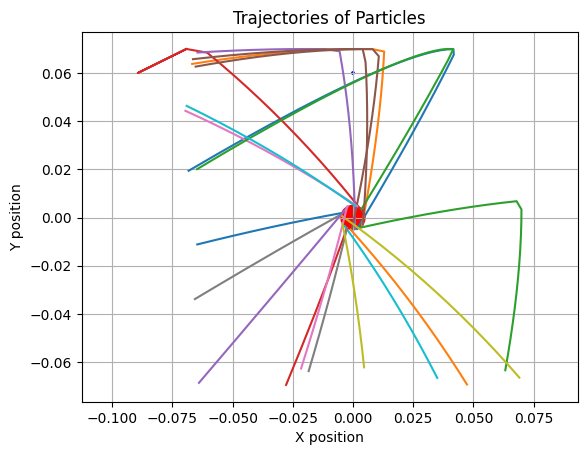

In [219]:
# Plot the trajectories of particles
plt.figure(figsize=(10, 8))
fig1, ax1 = plt.subplots()
circle1 = plt.Circle((0, 0), r_sphere, color='r')
circle2 = plt.Circle(needle_cords_1[0], r_needle, color='b', fill = True)

ax1.set(xlim=(-0.07, 0.07), ylim=(-0.07, 0.07))
ax1.add_artist(circle1)
ax1.add_artist(circle2)

for i in range(N):
    plt.plot(r[i, :, 0], r[i, :, 1], label=f'Particle {0+1}')

# Plot settings
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Trajectories of Particles')

plt.grid(True)
plt.axis('equal')  # Ensure equal scaling on both axes

plt.show()

[(-0.02, 0.04), (0.0, 0.04)]

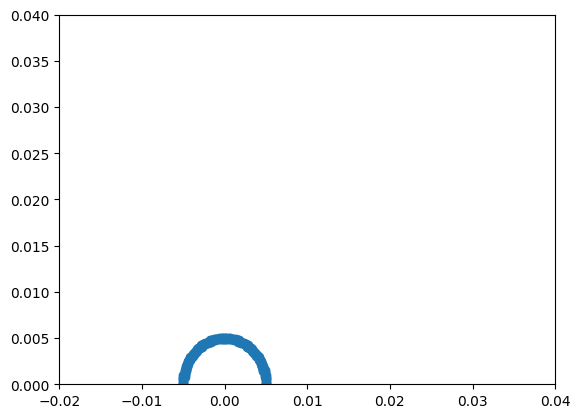

In [15]:

fig3, ax3 = plt.subplots()
ax3.scatter(xhalf, yhalf)
ax3.set(xlim=(-0.02, 0.04), ylim=(0, 0.04))